# Initialization

## Formatter

In [30]:
using JupyterFormatter
enable_autoformat()

1-element Vector{Function}:
 format_current_cell (generic function with 1 method)

## Load Packages

In [1]:
using HalfIntegers
using LinearAlgebra
using ElasticArrays
using JLD2
using Distributed
using DelimitedFiles
using Random
using CSV
using DataFrames
using LsqFit

## Plot style

In [2]:
using Plots
using Plots.PlotMeasures
using LaTeXStrings

# set backend and style
pgfplotsx()
theme(:default)
default(
    markerstrokewidth = 0,
    markerstrokealpha = 0,
    linewidth = 2,
    #grid=:none,   
    gridlinewidth = 0.5,
    markersize = 5,
    markershape = :circle,
    tickfontsize = 18,
    size = (900, 600),
    legendfontsize = 18,
    guidefontsize = 20,
    titlefontsize = 20,
    legend = (0.03, 0.98),
    xticks = 0:10,
    foreground_color_axis = "black",
    foreground_color_border = "black",
    foreground_color_guide = "darkorange",
    foreground_color_text = "black",
    guidefontcolor = "black",
    plot_titlefontcolor = "black",
    titlefontcolor = "black",
    shape = [:circle],
)

## Data

In [16]:
include("../../parameters.jl");
DATA_FOLDER = "../../data";
STORE_FOLDER = "./plots";

## Useful Function 

In [8]:
function Fromj0ToMass(j0_float)
    return round(sqrt(j0_float * immirzi), digits = 2)
end

Fromj0ToMass (generic function with 1 method)

In [9]:
function Fromj0Tojpm(j0_float)
    return round(Int64, 2 * (j0_float / (sqrt(6)))) / 2
end

Fromj0Tojpm (generic function with 1 method)

# Computational times

In [17]:
workers = 64
threads = 1

comp_times = Matrix(
    DataFrame(
        CSV.File(
            "../../immirzi_$(immirzi)_workers_$(workers)_threads_$(threads).csv",
            header = true,
        ),
    ),
);

In [18]:
pl1 = plot(
    1:11,
    [
        comp_times[:, 1],
        comp_times[:, 2],
        comp_times[:, 3],
        comp_times[:, 4],
        comp_times[:, 5],
        comp_times[:, 6],
        comp_times[:, 7],
        comp_times[:, 8],
        comp_times[:, 9],
    ],
    label = [L"j_0=1,\,j_{\pm}=0.5" L"j_0=1.5,\,j_{\pm}=0.5" L"j_0=2,\,j_{\pm}=1" L"j_0=2.5,\,j_{\pm}=1" L"j_0=3,\,j_{\pm}=1" L"j_0=3.5,\,j_{\pm}=1.5" L"j_0=4,\,j_{\pm}=1.5" L"j_0=4.5,\,j_{\pm}=2" L"j_0=5,\,j_{\pm}=2"],
    markershape = :circle,
    yaxis = :log,
    xaxis = :log,
    legend = (0.10, 0.97),
    legendfontsize = 18,
)
xticks!(
    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
    string.([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]),
)
xlabel!(L"\Delta l")
ylabel!(L"\textrm{seconds}")
title!(L"\textrm{Computation time of EPRL vertices}")
savefig(
    "./plots/narval_computation_workers_$(workers)_threads_$(threads)_immirzi_$(immirzi).pdf",
)

"/home/frisus/Scrivania/BlackToWhiteHole/notebooks/Julia/plots/narval_computation_workers_64_threads_1_immirzi_5.pdf"

# Amplitude

In [25]:
function AmplitudeAbsSquaredLoad(
    DATA_FOLDER,
    j0,
    jpm,
    alpha,
    immirzi,
    T,
    K0 = 0.5,
    Kpm = 0.5,
)
    return Matrix(
        DataFrame(
            CSV.File(
                "$(DATA_FOLDER)/amplitude_data/j0=$(j0)_jpm=$(jpm)/K0_$(K0)_Kpm_$(Kpm)/immirzi_$(immirzi)/alpha_$(alpha)/amplitude_abs_sq_T_$(T).csv",
                header = true,
            ),
        ),
    )
end

function AmplitudeRescaling(ampls, rescaling_factor = 100000000000000000000000000000000000000000000000000)
    ampls[:] .= ampls[:] .* rescaling_factor
end

function TRange(m, immirzi, T_sampling_parameter)
    return LinRange(0, 4 * pi * m / immirzi, T_sampling_parameter)
end

TRange (generic function with 1 method)

In [30]:
mkpath("$(STORE_FOLDER)/ampls")

for j0_index in angular_spins

    j0 = j0_index[1]
    jpm = Fromj0Tojpm(j0)
    m = Fromj0ToMass(j0)
    T_range = TRange(m, immirzi, T_sampling_parameter)
    
    DeltaT = Int(T_sampling_parameter/5)
    X_ticks = [0:DeltaT:T_sampling_parameter;]
    X_labels = String[]
    
    for x in X_ticks[1:end-1]
        l = T_range[x+1]
        l = round(l, digits=2)
        push!(X_labels, "$(l)")
    end
    
    push!(X_labels, L"\frac{4 \pi m}{\gamma}")

    ampls =
        AmplitudeAbsSquaredLoad(DATA_FOLDER, j0, jpm, alpha, immirzi, T_sampling_parameter)

    AmplitudeRescaling(ampls)

    final_x_tick = T_range[end]

    pl1 = plot(
        1:T_sampling_parameter,
        [
            ampls[:, 1] ampls[:, 2] ampls[:, 3] ampls[:, 4] ampls[:, 5] ampls[:, 6] ampls[:, 7] ampls[:, 8] ampls[:, 9] ampls[:, 10] ampls[:, 11];
        ],
        label = ["Δl=0" "Δl=1" "Δl=2" "Δl=3" "Δl=4" "Δl=5" "Δl=6" "Δl=7" "Δl=8" "Δl=9" "Δl=10"],
        legend = (0.35, 0.90),
        #label = "",
        markershape = :circle,
        grid = :true,
        xlims = (0, T_sampling_parameter+1),
        xticks = (X_ticks, X_labels),
        palette = palette([:skyblue, :purple], 11),
        legendfontsize = 20,
    )
    xlabel!(L"T")
    title!(L"|W_{\alpha=%$alpha}  \, \left(m=%$m, \, T \right) |^2 \times 10^{50}")
    savefig("$(STORE_FOLDER)/ampls/W_alpha_$(alpha)_Immirzi_$(immirzi)_j0_$(j0).pdf")

end

# Crossing Time

In [31]:
function CrossingTimeLoad(DATA_FOLDER, j0, jpm, alpha, immirzi, T, K0 = 0.5, Kpm = 0.5)
    return Matrix(
        DataFrame(
            CSV.File(
                "$(DATA_FOLDER)/amplitude_data/j0=$(j0)_jpm=$(jpm)/K0_$(K0)_Kpm_$(Kpm)/immirzi_$(immirzi)/alpha_$(alpha)/lifetime_$(T).csv",
                header = true,
            ),
        ),
    )
end

CrossingTimeLoad (generic function with 3 methods)

In [32]:
mkpath("$(STORE_FOLDER)/crossing_times")

crossing_times = Float64[]
mass_values = Float64[]
mass_values_string = String[]
n_points = size(angular_spins)[1]
semiclassical_estimate = Float64[]

for j0_index in angular_spins[1:end]

    j0 = j0_index[1]
    jpm = Fromj0Tojpm(j0)
    m = Fromj0ToMass(j0)

    crossing_time =
        CrossingTimeLoad(DATA_FOLDER, j0, jpm, alpha, immirzi, T_sampling_parameter)

    push!(crossing_times, crossing_time[end])
    push!(mass_values, m)
    push!(mass_values_string, "$(m)")
    push!(semiclassical_estimate, 2*m*pi/immirzi)

end

In [33]:
crossing_times_alpha = crossing_times

9-element Vector{Float64}:
 3.880644613316357
 4.932187782757526
 4.380113968984891
 4.093412613124284
 4.827425881653306
 5.256835507415121
 5.619845846059341
 5.960752951010757
 6.283185307179611

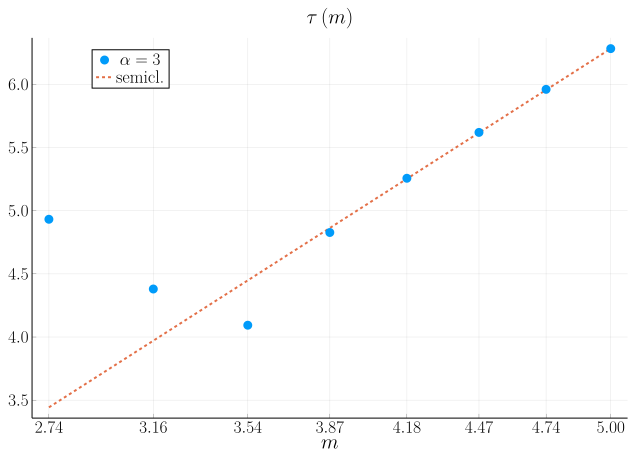

In [34]:
pl1 = scatter(
    mass_values[2:end],
    [[crossing_times_alpha[2:end]]], #crossing_times_alpha_4[2:end] crossing_times_alpha_5[2:end] crossing_times_alpha_6[2:end] crossing_times_alpha_8[2:end]]],
    label = [L"\alpha=3" L"\alpha=4" L"\alpha=5" L"\alpha=6" L"\alpha=8"],
    legend = (0.10, 0.97),
    markersize = 6,
    linewidth = -1,
    markershape = :circle,
    #linestyle = :none,
    legendfontsize = 18,
    xticks = mass_values,    
)
xlabel!(L"m")
title!(L"\tau \left(m \right)")

plot!(
    mass_values[2:end],
    [[semiclassical_estimate[2:end]]],
    label = "semicl.",
    linestyle = :dash,
    markershape = :none,
)

#savefig("$(STORE_FOLDER)/crossing_times/CT_Immirzi_$(immirzi)_T_$(T_sampling_parameter).pdf")